# Task D

This jupyter notebook aims to create a provenance graph to model road events in a city, then using PageRank to rank the nodes in the graph. Finally, using knowledge graph embeddings trained on CoDExMedium investigates the effectivness of knowledge graph embeddings to understand relations between nodes in the  provenanace netowrk.

Imports for Proverance and Pagerank

In [ ]:
from prov.model import ProvDocument
from prov.dot import prov_to_dot
import random
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython.display import Image
import pandas as pd
import os

Setup provenance document and NetworkX graph

In [3]:
document = ProvDocument()
document.add_namespace("Leeds", "Leeds")
document.add_namespace("Civ", "Civilian")
document.add_namespace("Pol", "Police")
police = document.agent("Pol:Police")

G = nx.DiGraph()

Functions to create events in the provernanace netowrk and the assosciations between things

In [4]:
# Generate driver and their car and the association between the two.
def createDriver(name):
    driver = document.agent("Civ:person_" + name)
    car = document.entity("Civ:car_" + name)
    document.wasAttributedTo(car, driver)
    G.add_edge(car, driver, relation = "wasAttributedTo")
    return (driver, car)

# Generate a car crash report, including the activity, and the associations between all the entities, activites, and agents. 
def createCarCrash(driverOne, driverTwo, street):
    car_crash_id = int(random.uniform(0,1 * 10)*1000)
    activity = document.activity(f"Civ:crash_car_{car_crash_id}")
    car_crash_report = document.entity(f"Pol:car_crash_report_{car_crash_id}" )
    document.used(activity, driverOne[1])
    G.add_edge(activity, driverOne[1],relation = "used")
    document.used(activity, driverTwo[1])
    G.add_edge(activity, driverTwo[1],relation = "used")
    document.used(activity, street)
    G.add_edge(activity, street,relation = "used")
    document.wasAssociatedWith(activity, driverOne[0])
    G.add_edge(activity, driverOne[0],relation = "wasAssociatedWith")
    document.wasAssociatedWith(activity, driverTwo[0])
    G.add_edge(activity, driverTwo[0],relation = "wasAssociatedWith")
    document.wasGeneratedBy(car_crash_report, activity)
    G.add_edge(car_crash_report, activity,relation = "wasGeneratedBy")
    document.wasAttributedTo(car_crash_report, police)
    G.add_edge(car_crash_report, police,relation = "wasAttributedTo")
    return car_crash_report

Create streets, drivers, and car crashes for the network

In [5]:
# Create the streets
streets = []
streets.append(document.entity("Leeds:Trent Street"))
streets.append(document.entity("Leeds:Thames Street"))
streets.append(document.entity("Leeds:Taf Street"))
# random_streets = random.choices(streets, [1,1,25,1], k=30)


# Create The Cars
driver_car_pairs = []
for i in range(0,8):
    driver_car_pairs.append(createDriver(str(i)))

# Create The Car Crashes
# for i in range(0,len(driver_car_pairs) - 1, 2):
#     createCarCrash(driver_car_pairs[i], driver_car_pairs[i+1], random_streets[i])
createCarCrash(driver_car_pairs[0], driver_car_pairs[1], streets[0])
createCarCrash(driver_car_pairs[2], driver_car_pairs[3], streets[0])
createCarCrash(driver_car_pairs[4], driver_car_pairs[5], streets[1])
createCarCrash(driver_car_pairs[6], driver_car_pairs[7], streets[2])

<ProvEntity: Pol:car_crash_report_618>

Visualize the prov docuement and the pagerank diagram

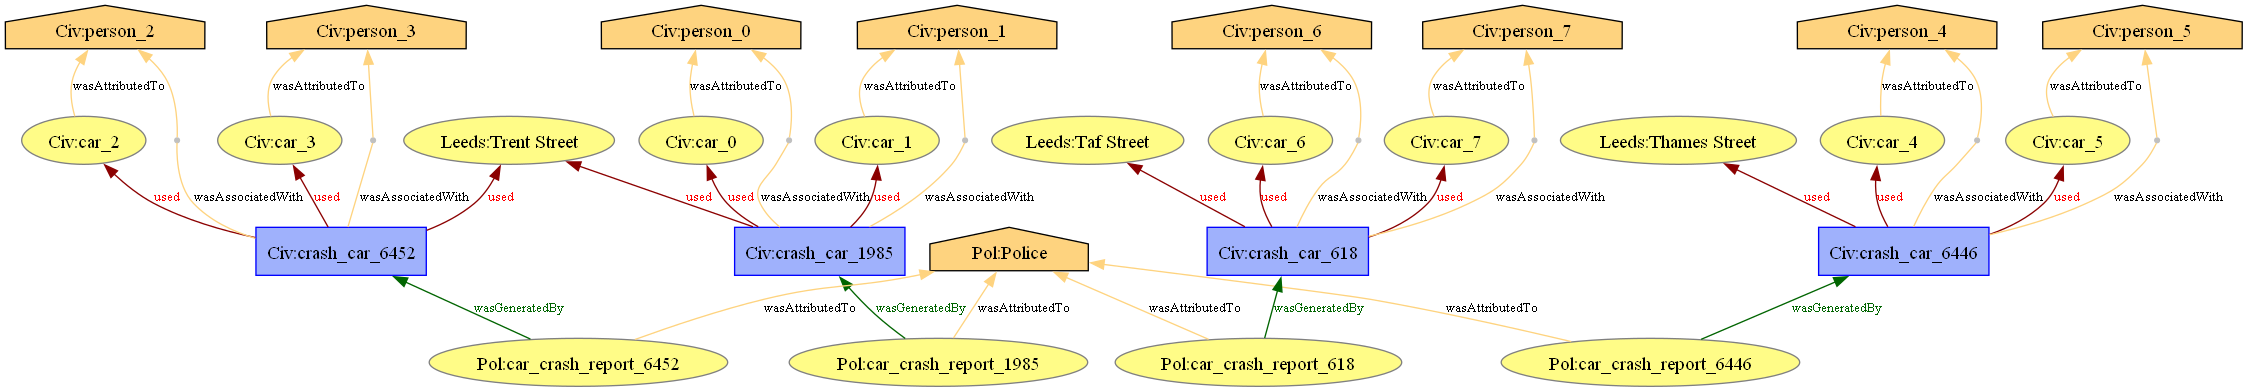

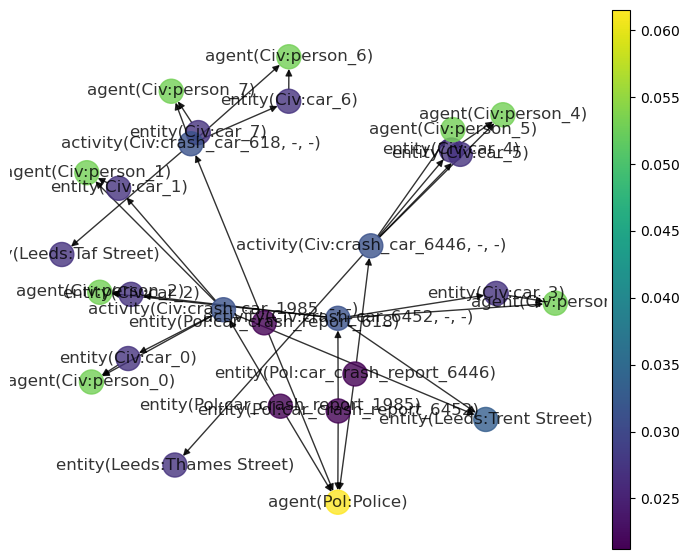

In [6]:
# Code from adapted from week 10 labs
# https://github.kcl.ac.uk/k21190656/7CUSMNDA-2024/blob/main/notebooks/week_10.ipynb
def plot_pagerank(graph, pagerank):
    fig, ax = plt.subplots(1, 1, figsize=(8, 7))

    node_color = list(pagerank.values())
    nx.draw(graph, with_labels=True, alpha=0.8, arrows=True, node_color=node_color, cmap=plt.cm.viridis) 

    # adding color bar for pagerank importances
    sm = plt.cm.ScalarMappable(cmap=plt.get_cmap('viridis'), norm=colors.Normalize(vmin=min(node_color), vmax=max(node_color)))
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    plt.colorbar(sm, cax=cax)

for f in ["leeds-prov.png", "leeds-pagerank.png"]:
    if os.path.isfile(f):
        os.remove(f)

dot = prov_to_dot(document)
plot_pagerank(G, nx.pagerank(G, alpha= 0.95))
plt.savefig("leeds-pagerank.png")
dot.write_png("leeds-prov.png")
Image(filename="leeds-prov.png")


Get most highly rated nodes in the network

In [7]:
list_of_tuples = [(key, value) for key, value in nx.pagerank(G, alpha= 0.95).items()]
list_of_tuples.sort(key = lambda x: x[1], reverse= True)
print(list_of_tuples[:6])

[(<ProvAgent: Pol:Police>, 0.06152480211571681), (<ProvAgent: Civ:person_0>, 0.052964447035174105), (<ProvAgent: Civ:person_1>, 0.052964447035174105), (<ProvAgent: Civ:person_2>, 0.052964447035174105), (<ProvAgent: Civ:person_3>, 0.052964447035174105), (<ProvAgent: Civ:person_4>, 0.052964447035174105)]


# Start of Knowledge Graph Embeddings
Imports for PyKeen

In [8]:
from pykeen.datasets import CoDExMedium
from pykeen.pipeline import pipeline
from pykeen.hpo import hpo_pipeline
from pykeen.evaluation import RankBasedEvaluator
from pykeen.sampling import BasicNegativeSampler
from pykeen.models import CompGCN
from pykeen.triples import TriplesFactory


c:\Users\Richard\miniconda3\envs\nda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import the CoDExMedium dataset for training and validation and provernance graph for testing

In [9]:
codex_dataset  = CoDExMedium(create_inverse_triples=False)

edges_relations_list = []

for edge in G.edges:
    source, target = edge
    relation = G.get_edge_data(source, target)["relation"]
    edges_relations_list.append((str(source), str(relation), str(target)))

dataset = pd.DataFrame(edges_relations_list, columns=["head", "relation", "tail"])
triples_factory = TriplesFactory.from_labeled_triples(dataset.values, create_inverse_triples = True)
training, testing, validation = triples_factory.split([0.8, 0.1, 0.1])

using automatically assigned random_state=1114364628


Hyperparameter Optmization for the three models

In [10]:
TRAILS = 20

model = ['TransE','RotatE', CompGCN]

def hpo_embedding(model):
    hpo_pipeline_result = hpo_pipeline(
        model = model,
        
        model_kwargs_ranges = dict(embedding_dim= dict(type=int, low=40, high=60)),
        # training_kwargs_ranges = dict(num_epochs= dict(type = int, low = 5, high = 25)),
        training_kwargs=dict(num_epochs = 10),
        optimizer_kwargs_ranges = dict(lr = dict(type="float", low=0.005, high=0.2)),

        # training_kwargs= dict(use_tqdm_batch=False),
        training = codex_dataset.factory_dict["training"],
        validation = codex_dataset.factory_dict["validation"],
        testing= triples_factory,
        device='gpu',
        training_loop='sLCWA',
        n_trials= TRAILS,
        negative_sampler=BasicNegativeSampler,
        evaluator=RankBasedEvaluator
    )

    return hpo_pipeline_result

TransE_result = hpo_embedding(model[0])
RotatE_result = hpo_embedding(model[1])

In [11]:
TRAILS = 20
codex_dataset = CoDExMedium(create_inverse_triples = True)
GCN_result = hpo_embedding(model[2])

[I 2024-04-21 02:16:09,627] A new study created in memory with name: no-name-a85860d0-fc9a-4c22-bfb7-56081b68c334
No random seed is specified. Setting to 816698218.
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1449 (0.07%) batches).
Training epochs on cuda:0: 100%|██████████| 10/10 [17:42<00:00, 106.23s/epoch, loss=56.4, prev_loss=12.7] 
Evaluating on cuda:0:   0%|          | 0.00/10.3k [00:00<?, ?triple/s]c:\Users\Richard\miniconda3\envs\nda\Lib\site-packages\pykeen\utils.py:537: RuntimeWarning: overflow encountered in scalar add
  return sum(
Evaluating on cuda:0: 100%|██████████| 10.3k/10.3k [00:02<00:00, 3.79ktriple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 11.62s seconds
[I 2024-04-21 02:34:04,334] Trial 0 finished with value: 0.05012497678399087

In [12]:

print(f"\n\nTransE :{TransE_result.study.best_params}")
print(f"\n\nRotatE: {RotatE_result.study.best_params}")
print(f"\n\nGCN: {GCN_result.study.best_params}")



TransE :{'model.embedding_dim': 51, 'model.scoring_fct_norm': 2, 'loss.margin': 0.6927973245597374, 'optimizer.lr': 0.006298802318475191, 'negative_sampler.num_negs_per_pos': 19, 'training.num_epochs': 16, 'training.batch_size': 2048}


RotatE: {'model.embedding_dim': 52, 'loss.margin': 2.988372134346883, 'optimizer.lr': 0.022586875582725083, 'negative_sampler.num_negs_per_pos': 99, 'training.num_epochs': 12, 'training.batch_size': 2048}


TransE

In [13]:
codex_dataset = CoDExMedium(create_inverse_triples = False)

In [14]:
TransE_pipeline_result = pipeline(
    model='TransE',
    model_kwargs=dict(embedding_dim = 51, scoring_fct_norm = 2, ),
    optimizer_kwargs=dict(lr = 0.006298802318475191),
    training_kwargs=dict(num_epochs = 16, batch_size = 2048, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    loss_kwargs=dict(margin = 0.6927973245597374),
    negative_sampler_kwargs=dict(num_negs_per_pos = 19),
    
    training = codex_dataset.factory_dict["training"],
    validation = codex_dataset.factory_dict["validation"],
    testing= triples_factory,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator
)

INFO:pykeen.pipeline.api:Using device: gpu
Training epochs on cuda:0: 100%|██████████| 16/16 [00:07<00:00,  2.11epoch/s, loss=0.114, prev_loss=0.115]
Evaluating on cuda:0: 100%|██████████| 36.0/36.0 [00:00<00:00, 923triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.52s seconds


RotatE

In [25]:
RotatE_pipeline_result = pipeline(
    model='RotatE',
    model_kwargs=dict(embedding_dim = 52),
    optimizer_kwargs=dict(lr = 0.022586875582725083),
    training_kwargs=dict(num_epochs = 12, batch_size = 2048, use_tqdm_batch=False),
    evaluation_kwargs=dict(use_tqdm=True),
    loss_kwargs=dict(margin = 2.988372134346883),
    negative_sampler_kwargs= dict(num_negs_per_pos = 99),
    
    training = codex_dataset.factory_dict["training"],
    validation = codex_dataset.factory_dict["validation"],
    testing= triples_factory,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator
)

INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cuda:0: 100%|██████████| 12/12 [00:40<00:00,  3.41s/epoch, loss=0.126, prev_loss=0.133]
Evaluating on cuda:0: 100%|██████████| 36.0/36.0 [00:00<00:00, 783triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.55s seconds


GCN

In [17]:
codex_dataset = CoDExMedium(create_inverse_triples = True)

In [18]:
GCN_pipeline_result = pipeline(
    model=CompGCN,
    model_kwargs=dict(embedding_dim=50),
    optimizer_kwargs=dict(lr=1.0e-2),
    training_kwargs=dict(num_epochs=2, use_tqdm_batch=True),
    evaluation_kwargs=dict(use_tqdm=False),
    
    training = codex_dataset.factory_dict["training"],
    validation = codex_dataset.factory_dict["validation"],
    testing= triples_factory,
    device='gpu',
    training_loop='sLCWA',
    negative_sampler=BasicNegativeSampler,
    evaluator=RankBasedEvaluator
)

INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.
Training epochs on cuda:0:   0%|          | 0/2 [00:00<?, ?epoch/s]INFO:pykeen.triples.triples_factory:Creating inverse triples.
INFO:pykeen.training.training_loop:Dropping last (incomplete) batch each epoch (1/1449 (0.07%) batches).
Training epochs on cuda:0: 100%|██████████| 2/2 [03:20<00:00, 100.26s/epoch, loss=0.134, prev_loss=0.374]
Evaluating on cuda:0: 100%|██████████| 36.0/36.0 [00:00<00:00, 735triple/s]
INFO:pykeen.evaluation.evaluator:Evaluation took 0.60s seconds


Visualise TransE, RotatE, and GCN

<Axes: title={'center': 'Entity Plot using PCA'}>

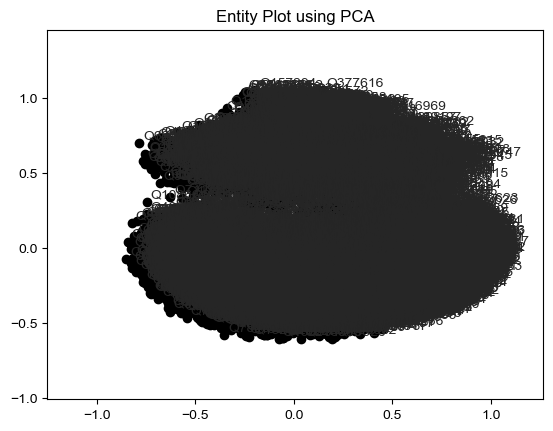

In [19]:
TransE_pipeline_result.plot_er(plot_relations=False)
# save as leeds-TransE-embedding.png

In [ ]:
RotatE_pipeline_result.plot_er(plot_relations=False)
# save as leeds-RotatE-embedding.png

<Axes: title={'center': 'Entity Plot using PCA'}>

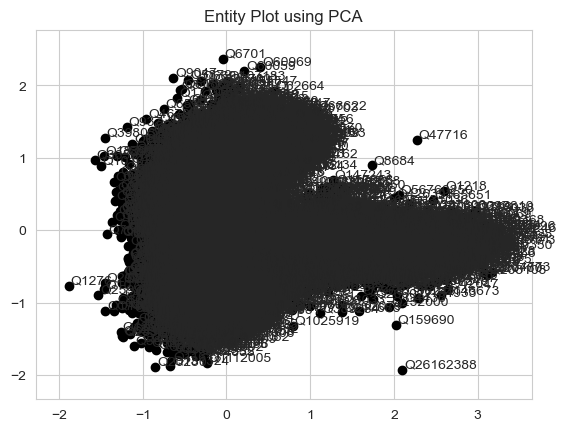

In [21]:
GCN_pipeline_result.plot_er(plot_relations=False)
# save as leeds-GCN-embedding.png

Evalaluate TransE, RotatE, and GCN

In [28]:
TransE_Emrr = TransE_pipeline_result.get_metric('mrr')
TransE_hits_at_10 = TransE_pipeline_result.get_metric('hits@k')

RotatE_Emrr = RotatE_pipeline_result.get_metric('mrr')
RotatE_hits_at_10 = RotatE_pipeline_result.get_metric('hits@k')

GCN_Emrr = GCN_pipeline_result.get_metric('mrr')
GCN_hits_at_10 = GCN_pipeline_result.get_metric('hits@k')

print(f"Mean Reciprocal Rank\n\t TransE: {TransE_Emrr} | RotatE: {RotatE_Emrr} | GCN: {GCN_Emrr}")
print(f"Hits at 10k\n\t TransE: {TransE_hits_at_10} | RotatE: {RotatE_hits_at_10} | GCN: {GCN_hits_at_10}")

Mean Reciprocal Rank
	 TransE: 0.0008756694151088596 | RotatE: 0.004057030193507671 | GCN: 0.0003047495847567916
Hits at 10k
	 TransE: 0.0 | RotatE: 0.013888888888888888 | GCN: 0.0


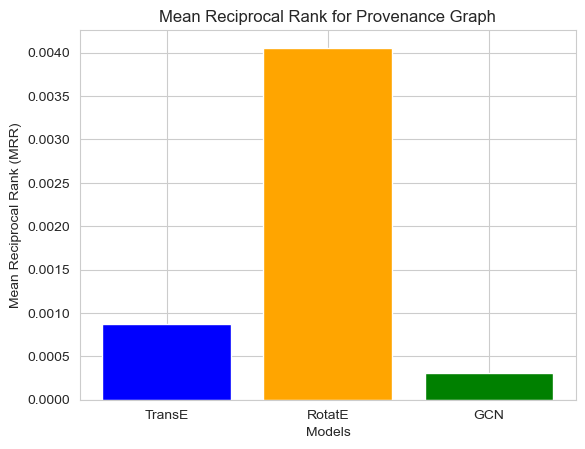

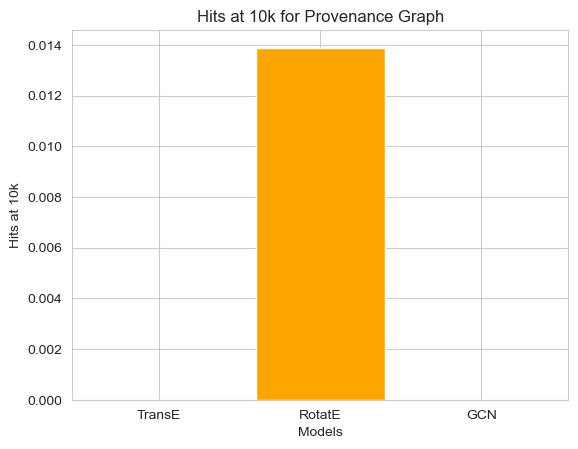

<Figure size 640x480 with 0 Axes>

In [29]:
models = ['TransE', 'RotatE', 'GCN']
mrr_scores = [TransE_Emrr, RotatE_Emrr, GCN_Emrr]
hits_at_10_scores = [TransE_hits_at_10, RotatE_hits_at_10, GCN_hits_at_10]

plt.bar(models, mrr_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Mean Reciprocal Rank (MRR)')
plt.title('Mean Reciprocal Rank for Provenance Graph')
plt.show()
plt.savefig("mrr_scores_fig.png")

plt.bar(models, hits_at_10_scores, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Hits at 10k')
plt.title('Hits at 10k for Provenance Graph')
plt.show()
plt.savefig("Hits10K_fig.png")